In [1]:
import os
from os.path import join, exists
import multiprocessing
import hashlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import IPython.display as display
from PIL import Image
import random

import pandas as pd

from src.crop_api import ImageSaliencyModel, is_symmetric, parse_output, reservoir_sampling
from src.image_manipulation import join_images

In [2]:
data_dir = "./data/"
files = ['facescrub_actors.txt', 'facescrub_actresses.txt']

# Preemptively apologizing for limiting ourselves to the gender binary. 
# Judith Butler would be sad.
names = list()
images = list()
gender = list()

for f in files:
    with open(data_dir + f, 'r', encoding='utf-8') as fd:
        fd.readline()
        for line in fd.readlines():
            components = line.split('\t')
            name = components[0].replace(' ', '_')
            url = components[3]
            fname = hashlib.sha1(url.encode()).hexdigest() + '.jpg'
            names.append(name)
            images.append(fname)
            gender.append('m' if f == "facescrub_actors.txt" else 'f')

In [51]:
df = pd.DataFrame(list(zip(names, images, gender)), columns = ["name", "image", "gender"])
df.info()
df.head()
df.gender.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106863 entries, 0 to 106862
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    106863 non-null  object
 1   image   106863 non-null  object
 2   gender  106863 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


m    55306
f    51557
Name: gender, dtype: int64

In [52]:
# Removing entries where we couldn't get files
df = df[df.image.isin(os.listdir(join(data_dir, "images")))]
df.reset_index(inplace=True)

In [53]:
df.info()
df.gender.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53888 entries, 0 to 53887
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   53888 non-null  int64 
 1   name    53888 non-null  object
 2   image   53888 non-null  object
 3   gender  53888 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


m    28254
f    25634
Name: gender, dtype: int64

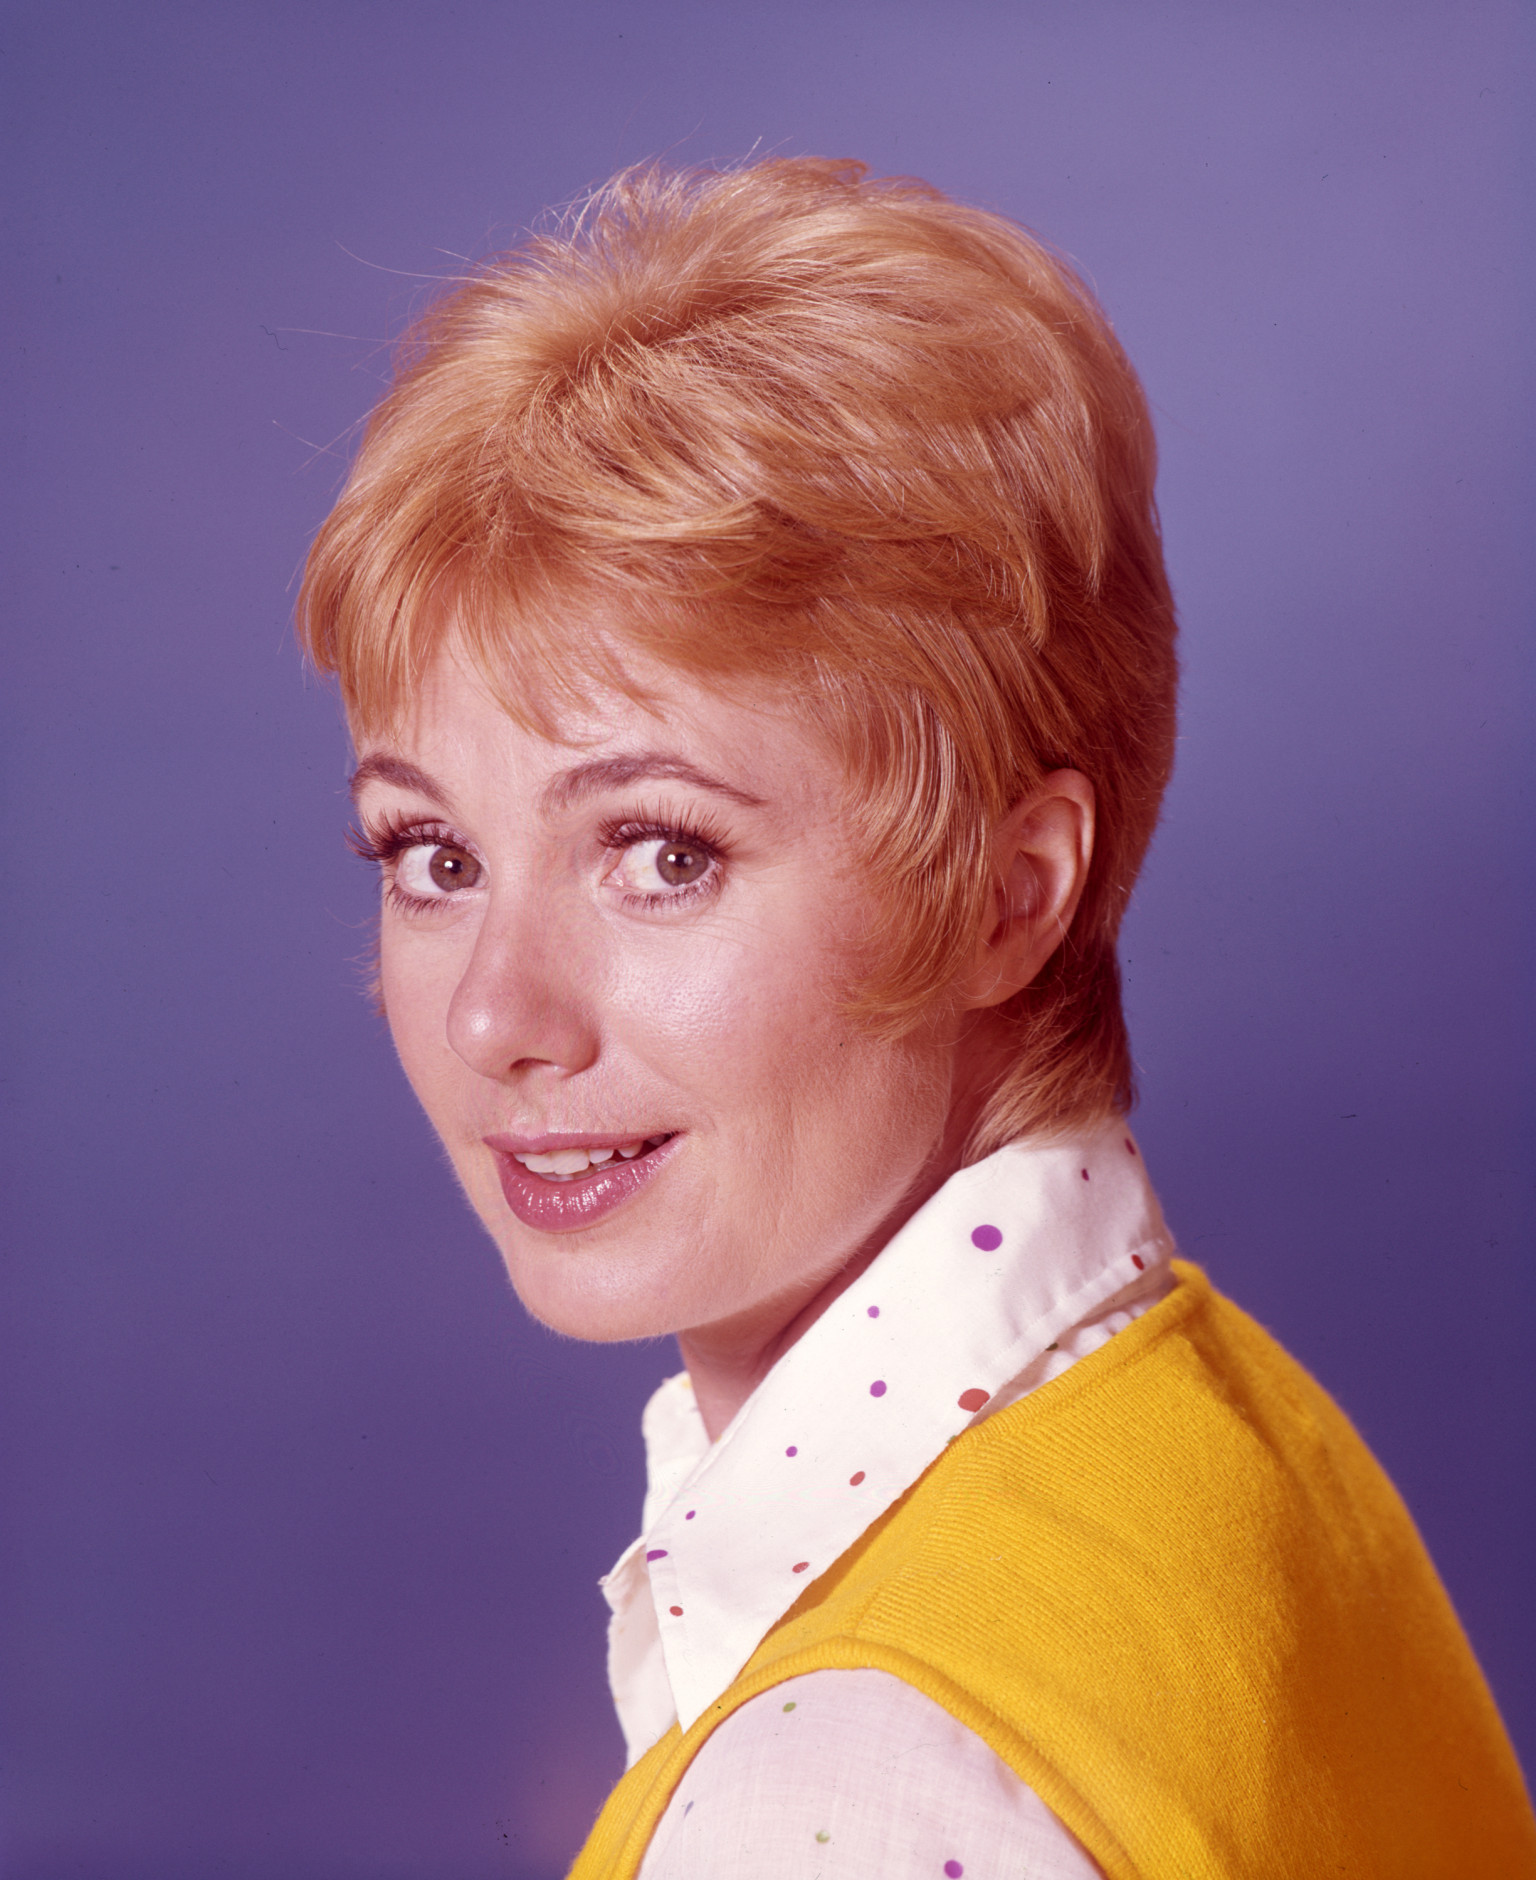

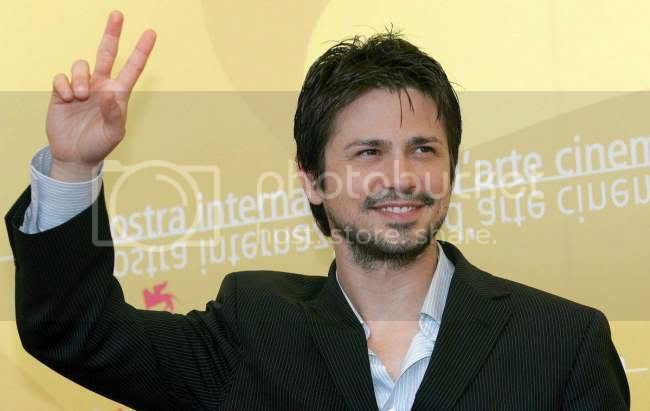

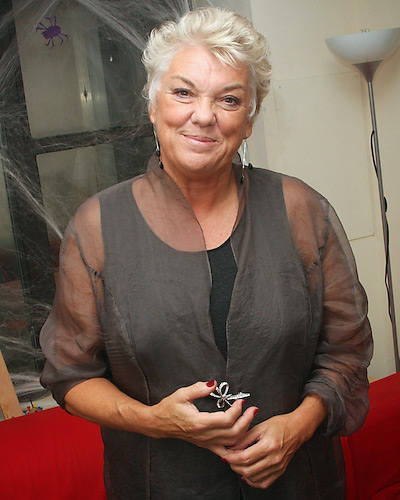

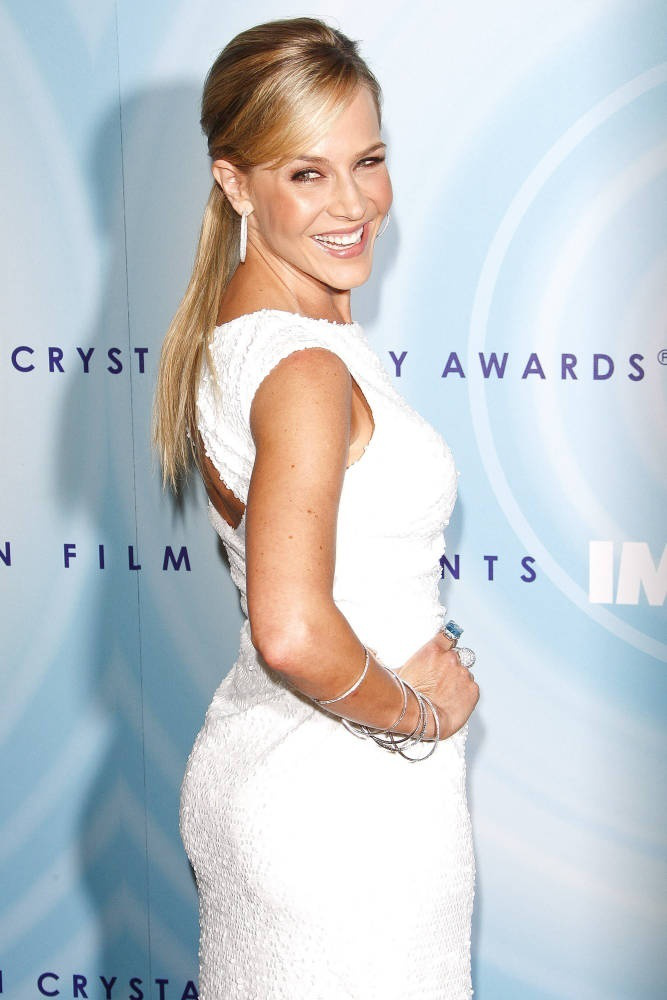

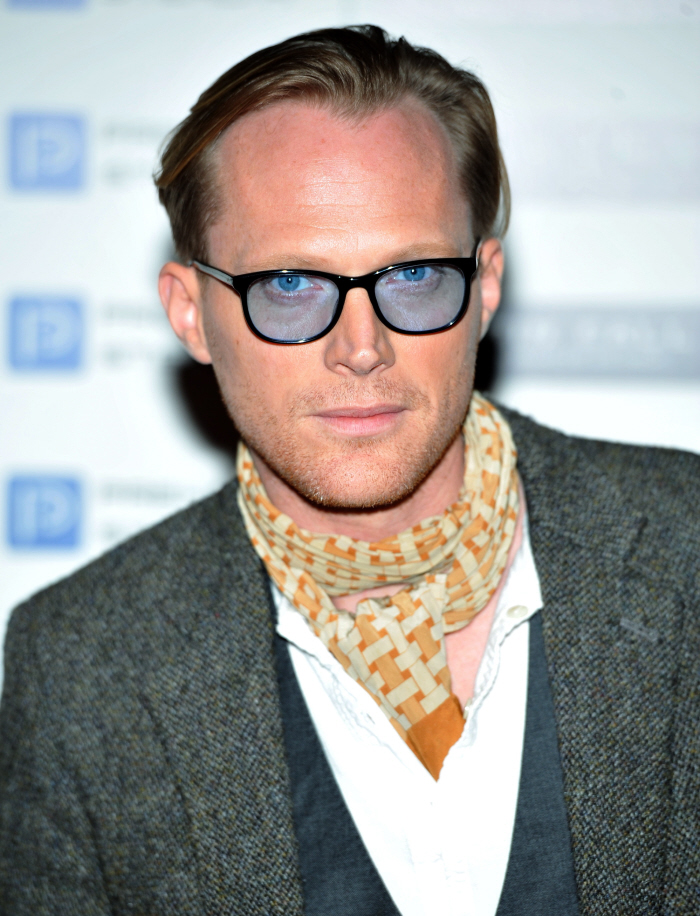

In [7]:
for _ in range(5):
    r = random.randint(0, len(df))
    im = Image.open(join(data_dir, "images", df["image"][r]))
    display.display(im)

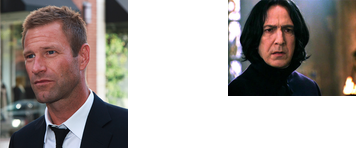

In [18]:
im1 = Image.open(join(data_dir, "images", df["image"][0]))
im2 = Image.open(join(data_dir, "images", df["image"][1000]))
two_imgs = [im1, im2]

join_images(two_imgs, col_wrap = 2, img_size=(128, -1), padding=100)

In [19]:
crop_path = join("./bin", "linux", "candidate_crops")
model_path = join("./bin", "fastgaze.vxm")
model = ImageSaliencyModel(crop_binary_path=crop_path, crop_model_path=model_path)

In [29]:
im1 = Image.open(join(data_dir, "images", df["image"][0]))
im2 = Image.open(join(data_dir, "images", df["image"][1000]))
two_imgs = [im1, im2]

img = join_images(two_imgs, col_wrap = 2, img_size=(128, -1), padding=100)

/tmp/tmpweyle4wl
None 356 148


showAllPoints=true, argv[3]=show_all_points


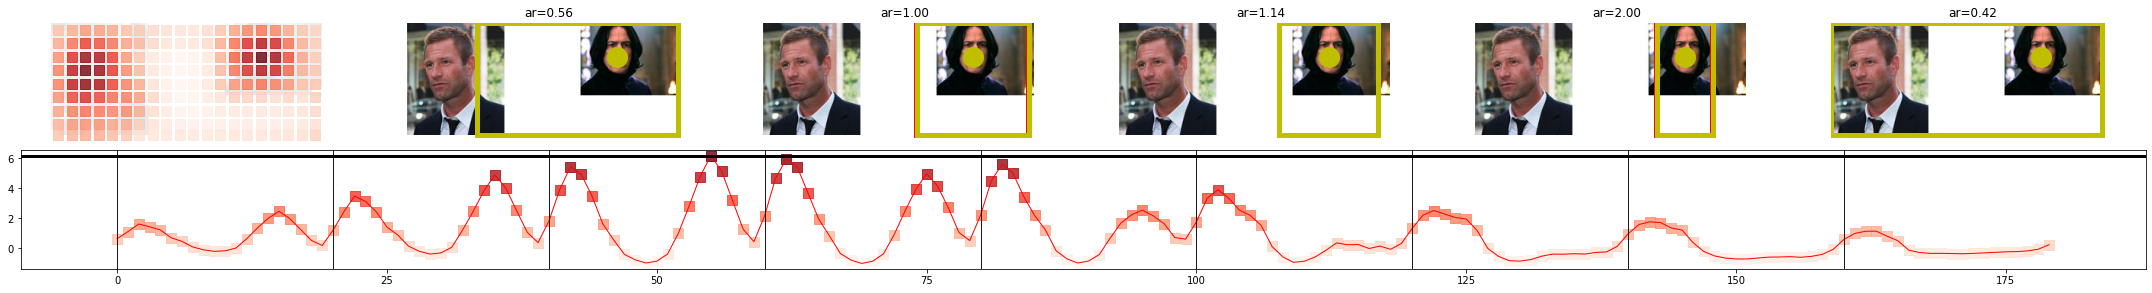

In [30]:
model.plot_img_crops_using_img(img)

In [45]:
img_path = join(data_dir, "test", "example.jpeg")
img.save(img_path)

In [34]:
import subprocess

output = subprocess.check_output(f"{str(crop_path)} {str(model_path)} '{str(img_path)}' show_all_points", 
                                 shell=True)

showAllPoints=true, argv[3]=show_all_points


In [36]:
# Taken directly from Image Crop Analysis paper
# https://github.com/twitter-research/image-crop-analysis/blob/main/notebooks/Demographic%20Bias%20Analysis.ipynb
def parse_output(output):
    output = output.splitlines()
    final_output = {"salient_point": [], "crops": [], "all_salient_points": []}
    key = "salient_point"
    for i, line in enumerate(output):
        line = line.split()
        if len(line) in {2, 4}:
            line = [int(v) for v in line]
            if i != 0:
                key = "crops"
        elif len(line) == 3:
            key = "all_salient_points"
            line = [float(v) for v in line]
        else:
            raise RuntimeError(f"Invalid line: {line}")
        final_output[key].append(line)
    return final_output

In [37]:
parse_output(output)

{'salient_point': [[275, 44]],
 'crops': [[92, 0, 264, 148],
  [201, 0, 148, 148],
  [210, 0, 130, 148],
  [238, 0, 74, 148],
  [0, 0, 356, 148]],
 'all_salient_points': [[8.9, 8.9, 0.629232],
  [26.7, 8.9, 1.09873],
  [44.5, 8.9, 1.60904],
  [62.3, 8.9, 1.42259],
  [80.1, 8.9, 1.21346],
  [97.9, 8.9, 0.689623],
  [115.7, 8.9, 0.446598],
  [133.5, 8.9, 0.0766702],
  [151.3, 8.9, -0.118486],
  [169.1, 8.9, -0.220499],
  [186.9, 8.9, -0.184912],
  [204.7, 8.9, -0.00152338],
  [222.5, 8.9, 0.621824],
  [240.3, 8.9, 1.34837],
  [258.1, 8.9, 1.99409],
  [275.9, 8.9, 2.45766],
  [293.7, 8.9, 1.96857],
  [311.5, 8.9, 1.24127],
  [329.3, 8.9, 0.512895],
  [347.1, 8.9, 0.171354],
  [8.9, 26.7, 1.18913],
  [26.7, 26.7, 2.41623],
  [44.5, 26.7, 3.47281],
  [62.3, 26.7, 3.11954],
  [80.1, 26.7, 2.43749],
  [97.9, 26.7, 1.39819],
  [115.7, 26.7, 0.876512],
  [133.5, 26.7, 0.126375],
  [151.3, 26.7, -0.217481],
  [169.1, 26.7, -0.399483],
  [186.9, 26.7, -0.322355],
  [204.7, 26.7, 0.0525852],
  [22

In [41]:
output_dict = parse_output(output)
salient_point_x = output_dict["salient_point"][0][0]

In [44]:
# Determine if salient point is on the left or right side of the image
# True is right image most salient, False is left image most salient
salient_point_x >= img.width/2

True

In [46]:
# We'll need to randomize the order of the input since randomizing in the function will be more of a pain.
def gender_salience(img1, img2, gender1, gender2, count):
    """Given two images and the (binary) gender of the subject of each image, return the gender of the 
    subject whose image contained the most salient point"""
    joint_img = join_images([img1, img2], col_wrap = 2, img_size=(128, -1), padding=100)
    img_path = join(data_dir, "test", f"test_{count}.jpeg")
    joint_img.save(img_path)
    
    cmd = f"{str(crop_path)} {str(model_path)} '{str(img_path)}' show_all_points"
    output = subprocess.check_output(cmd ,shell=True)
    output_dict = parse_output(output)
    salient_point_x = output_dict["salient_point"][0][0]
    if salient_point_x > joint_img.width/2:
        return gender2
    else:
        return gender1

In [55]:
for i in range(5):
    random1 = random.randint(0, 20000)
    random2 = random.randint(20000, 40000)
    
    sample_img1 = df["image"].iloc[random1]
    sample_img1 = Image.open(join(data_dir, "images", sample_img1))
    sample_gender1 = df["gender"].iloc[random1]
    
    sample_img2 = df["image"].iloc[random2]
    sample_gender2 = df["gender"].iloc[random2]
    sample_img2 = Image.open(join(data_dir, "images", sample_img2))
    
    result = gender_salience(sample_img1, sample_img2, sample_gender1, sample_gender2, i)
    print(result)

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points


f
m
f
m
m


showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
